Arturo Freydig Avila

# COVID-19 Notebook

Note, this notebook has NO medical value. Please use it for reference purposes ONLY.

#### Libraries

In [267]:
# Various Required Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import os
from sklearn.preprocessing import MinMaxScaler
import random
from scipy import ndarray
import seaborn as sns
import cv2
import time
import argparse
from PIL import Image

# Image processing Library
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io

# Deep Learning Libraries
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Dense, Activation, Flatten
from keras.layers import LSTM, SimpleRNN, GRU
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.models import model_from_json


np.random.seed(1671) # for reproducibility

## 1. COVID-19 X-Ray Image Detection

Let's start with a binary classification problem, healthy lung or COVID-19 positive. By no means this may replace a COVID-19 test. However, in developing communities where testing is limited a model based on X-Rays might be a good starting point to determine likely COVID-19 cases and quarantine such people. The idea is based on work ArXiV papers posted over the last months. 

1. [Extracting possibly representative COVID-19 Biomarkers from X-Ray images with Deep Learning approach and image data related to Pulmonary Diseases](https://arxiv.org/abs/2004.00338)
2. [COVID-19 Screening on Chest X-ray Images Using Deep Learning based Anomaly Detection](https://arxiv.org/abs/2003.12338)
3. [Automatic Detection of Coronavirus Disease (COVID-19) Using X-ray Images and Deep Convolutional Neural Networks](https://arxiv.org/ftp/arxiv/papers/2003/2003.10849.pdf)


## Data Augmentation

There are not enough [COVID-19 X-rays](https://github.com/ieee8023/covid-chestxray-dataset) in free datasets, so we first need to start by augmenting the data to create 1,583 COVID-19 X-ray images. The augmentation will consist in random rotations, flips and adding noise. The healthy X-rays are taken from [here](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5).

#### Augmentation Options

In [4]:
# Rotation
def random_rotation(image_array: ndarray):
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)
# Noise
def random_noise(image_array: ndarray):
    return sk.util.random_noise(image_array)
# Flip
def horizontal_flip(image_array: ndarray):
    return image_array[:, ::-1]

#### Augmentation Processes

In [5]:
# dictionary of the transformations we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}
# Define number of augmentations and path
folder_path = 'C:/Users/artur/Downloads/chest-xray-covid/chest_xray/COVID'
num_files_desired = 1000

# find all files paths from the folder
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

num_generated_files = 0
while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)
    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    num_transformations = 0
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1

    new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)
    # Save Augmented Images
    io.imsave(new_file_path, transformed_image)
    num_generated_files += 1

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

## Visualize Data

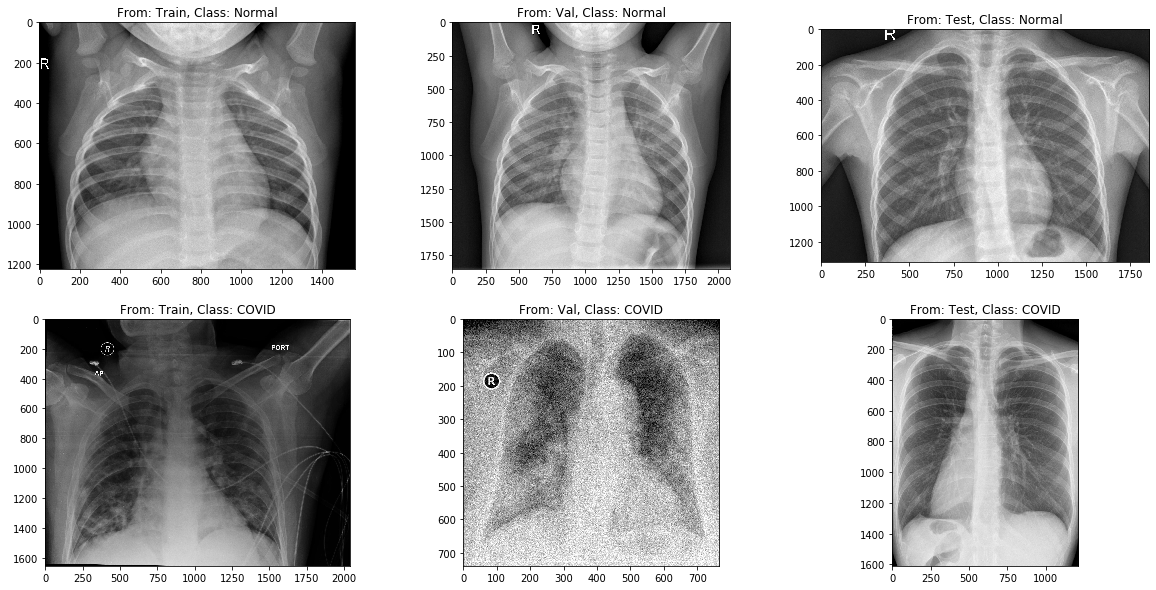

In [276]:
fig, a = plt.subplots(2, 3, figsize=(20, 10))
a = a.ravel() 
input_path = 'C:/Users/artur/Downloads/chest-xray-covid/chest_xray/'

# Read Images and Plot
for i, _set in enumerate(['Train', 'Val', 'Test']):
    set_name = input_path+_set # Path name
    a[i].imshow(plt.imread(set_name+'/NORMAL/'+os.listdir(set_name+'/NORMAL')[0]), cmap='gray') # Show Image
    a[i+3].imshow(plt.imread(set_name+'/COVID/'+os.listdir(set_name+'/COVID')[0]), cmap='gray') # Show Image
    a[i].set_title('From: {}, Class: Normal'.format(_set)) # Title Name
    a[i+3].set_title('From: {}, Class: COVID'.format(_set)) # Title Name

## Data Preprocessing

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

# Train, Validation, and Test Data (60/20/20-split)
xy_training = train_datagen.flow_from_directory('C:/Users/artur/Downloads/chest-xray-covid/chest_xray/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

xy_val = test_datagen.flow_from_directory('C:/Users/artur/Downloads/chest-xray-covid/chest_xray/val',
                                                target_size=(64, 64),
                                                batch_size=32,
                                                class_mode='binary')

xy_test = test_datagen.flow_from_directory('C:/Users/artur/Downloads/chest-xray-covid/chest_xray/test',
                                                target_size = (64, 64),
                                                batch_size = 32,
                                                class_mode = 'binary')

Found 1900 images belonging to 2 classes.
Found 634 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


### CNN Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1605888   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

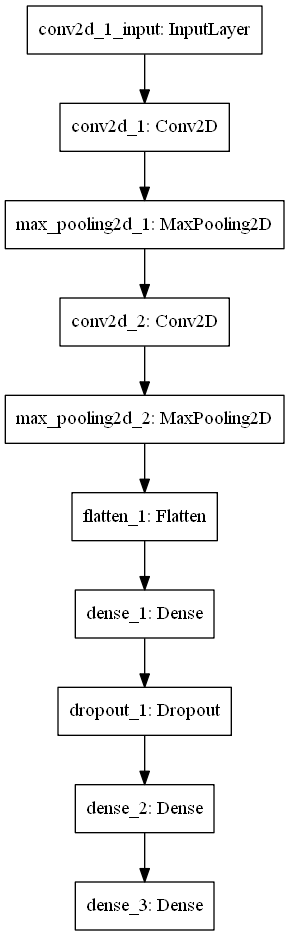

In [4]:
# Define Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(activation = 'relu', units = 256, ))
model.add(Dropout(0.1))
model.add(Dense(activation = 'relu', units = 128))
model.add(Dense(activation = 'sigmoid', units = 1))

# Compile CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()
plot_model(model, to_file='model.png') 
# if not working on Windows use: conda install python-graphviz
# SVG(model_to_dot(model).create(prog='dot', format='svg')) #bigger plot

### Train and Test Model

In [5]:
model_fit = model.fit_generator(xy_training,
                         steps_per_epoch = 60,
                         epochs = 5,
                         validation_data = xy_val,
                         validation_steps = 634)

test_accu = model.evaluate_generator(xy_test,steps=632)

Epoch 1/5
60/60 [==============================] - 356s 6s/step - loss: 0.3383 - accuracy: 0.8332 - val_loss: 0.0184 - val_accuracy: 0.9984
Epoch 2/5
60/60 [==============================] - 356s 6s/step - loss: 0.0969 - accuracy: 0.9700 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 3/5
60/60 [==============================] - 352s 6s/step - loss: 0.0668 - accuracy: 0.9784 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 4/5
60/60 [==============================] - 347s 6s/step - loss: 0.0467 - accuracy: 0.9858 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 5/5
60/60 [==============================] - 351s 6s/step - loss: 0.0380 - accuracy: 0.9911 - val_loss: 0.0059 - val_accuracy: 1.0000


### Model Accuracy and Score

In [271]:
print('The testing accuracy is :',test_accu[1]*100, '%')
print('The testing score is :',100 - test_accu[0]*100, '%')

The testing accuracy is : 98.25791120529175 %
The testing score is : 91.58403426408768 %


### Accuracy and Loss Plots

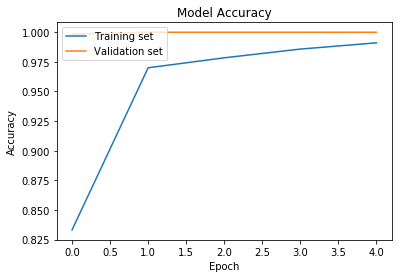

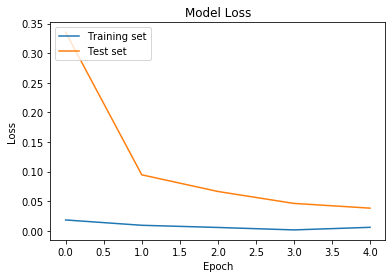

In [7]:
# Accuracy 
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

# Loss 
plt.plot(model_fit.history['val_loss'])
plt.plot(model_fit.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

## 2. COVID-19 Future Cases Model Prediction

Another way Machine Learning can be used to combat COVID-19 is predicting it. Using RNNs, LSTMs, and GRUs simple Deep Learning Models can be created to predict the spred of the virus.

#### RNN, LSTM, and GRU
RNN are a popular way to add memory to vanilla feedforward neural networks. By looping back the output to a neuron, we can add a recurrent neuron with "memory". However, RNN often have long-term memory issues, mainly because it has no weights. LSTMs are a smart solution which adds weights (sigmoid activation functions) as forget, input, and output gates. A simplifaction of LSTMs are GRUs where the forget and input gates are merged together.

### Data Preprocessing

Data taken from the Mexican Government [website](https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico).

In [242]:
dataset_train = pd.read_csv('C:/Users/artur/Downloads/Mexico_COVID19.csv')
training_set  = dataset_train.iloc[:, 1:2]
dataset_test  = pd.read_csv('C:/Users/artur/Downloads/Mexico_COVID19_TEST.csv')
COVID_cases   = dataset_test.iloc[:, 1:2].values
dataset_test.head()

,Date,TOT_N
0,3/31/2020,13528
1,4/1/2020,14776
2,4/2/2020,16115
3,4/3/2020,17416
4,4/4/2020,18183


#### Normalize Between 0 and 1 Using SciKit Learn

In [243]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

#### Create Training Data

In [244]:
X_train = []
y_train = []
for i in range(2, 90):
    X_train.append(training_set_scaled[i-2:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#### Create Testing Data

In [245]:
dataset_total = pd.concat((dataset_train['TOT_N'], dataset_test['TOT_N']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 2:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(2, 16):
    X_test.append(inputs[i-2:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Models

### RNN Model

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 2, 50)             2600      
_________________________________________________________________
dropout_144 (Dropout)        (None, 2, 50)             0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 2, 50)             5050      
_________________________________________________________________
dropout_145 (Dropout)        (None, 2, 50)             0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 2, 50)             5050      
_________________________________________________________________
dropout_146 (Dropout)        (None, 2, 50)             0         
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 50)              

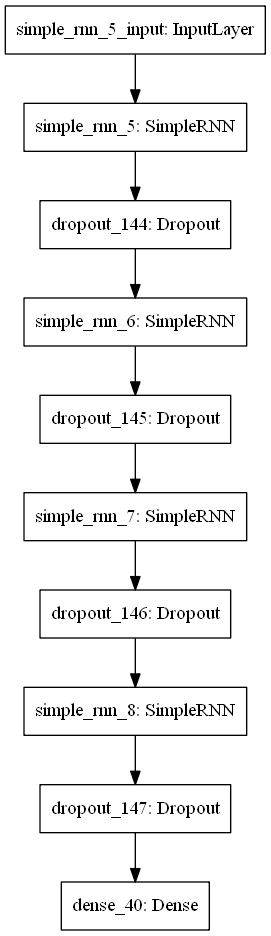

In [248]:
model_RNN = Sequential()
model_RNN.add(SimpleRNN(50, return_sequences = True, input_shape=(X_train.shape[1],1)))
model_RNN.add(Dropout(0.2))
model_RNN.add(SimpleRNN(50, return_sequences = True))
model_RNN.add(Dropout(0.2))
model_RNN.add(SimpleRNN(50, return_sequences = True))
model_RNN.add(Dropout(0.2))
model_RNN.add(SimpleRNN(50))
model_RNN.add(Dropout(0.2))
# Dense Layer
model_RNN.add(Dense(1))
# Compile
model_RNN.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Info
model_RNN.summary()
plot_model(model_RNN, to_file='model_RNN.png') 

### LSTM Model

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_120 (LSTM)              (None, 2, 50)             10400     
_________________________________________________________________
dropout_152 (Dropout)        (None, 2, 50)             0         
_________________________________________________________________
lstm_121 (LSTM)              (None, 2, 50)             20200     
_________________________________________________________________
dropout_153 (Dropout)        (None, 2, 50)             0         
_________________________________________________________________
lstm_122 (LSTM)              (None, 2, 50)             20200     
_________________________________________________________________
dropout_154 (Dropout)        (None, 2, 50)             0         
_________________________________________________________________
lstm_123 (LSTM)              (None, 50)              

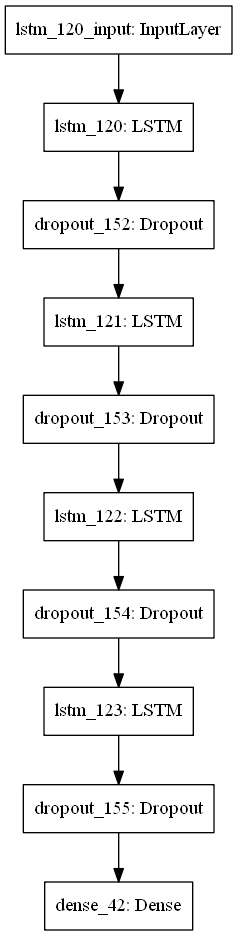

In [250]:
model_LSTM = Sequential()
# LSTM
model_LSTM.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(50, return_sequences = True))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(50, return_sequences = True))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(50))
model_LSTM.add(Dropout(0.2))
# Dense Layer
model_LSTM.add(Dense(1))
# Compile
model_LSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')
#Info
model_LSTM.summary()
plot_model(model_LSTM, to_file='model_LSTM.png') 

### GRU Model

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_25 (GRU)                 (None, 2, 50)             7800      
_________________________________________________________________
dropout_156 (Dropout)        (None, 2, 50)             0         
_________________________________________________________________
gru_26 (GRU)                 (None, 2, 50)             15150     
_________________________________________________________________
dropout_157 (Dropout)        (None, 2, 50)             0         
_________________________________________________________________
gru_27 (GRU)                 (None, 2, 50)             15150     
_________________________________________________________________
dropout_158 (Dropout)        (None, 2, 50)             0         
_________________________________________________________________
gru_28 (GRU)                 (None, 50)              

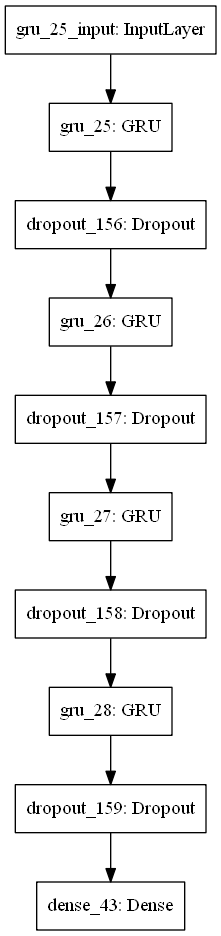

In [251]:
model_GRU = Sequential()
# GRU
model_GRU.add(GRU(50, return_sequences = True, input_shape=(X_train.shape[1],1)))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(50, return_sequences = True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(50, return_sequences = True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(50))
model_GRU.add(Dropout(0.2))
# Dense Layer
model_GRU.add(Dense(1))
# Compile
model_GRU.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Info
model_GRU.summary()
plot_model(model_GRU, to_file='model_GRU.png') 

### Training Models

#### RNN

In [252]:
model_RNN.fit(X_train, y_train, epochs = 50, batch_size = 32, verbose=1, validation_split=0.05)

Train on 83 samples, validate on 5 samples
Epoch 1/50
83/83 [==============================] - 1s 8ms/step - loss: 0.0062 - val_loss: 0.0035
Epoch 2/50
83/83 [==============================] - 0s 0us/step - loss: 0.0079 - val_loss: 0.0012
Epoch 3/50
83/83 [==============================] - 0s 297us/step - loss: 0.0048 - val_loss: 0.0299
Epoch 4/50
83/83 [==============================] - 0s 132us/step - loss: 0.0060 - val_loss: 0.0010
Epoch 5/50
83/83 [==============================] - 0s 144us/step - loss: 0.0055 - val_loss: 0.0591
Epoch 6/50
83/83 [==============================] - 0s 120us/step - loss: 0.0072 - val_loss: 0.1259
Epoch 7/50
83/83 [==============================] - 0s 120us/step - loss: 0.0051 - val_loss: 0.0901
Epoch 8/50
83/83 [==============================] - 0s 132us/step - loss: 0.0032 - val_loss: 0.0310
Epoch 9/50
83/83 [==============================] - 0s 120us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 10/50
83/83 [==============================] - 0s 132us

#### LSTM

In [254]:
model_LSTM.fit(X_train, y_train, epochs = 50, batch_size = 32, verbose=1, validation_split=0.05)

Train on 83 samples, validate on 5 samples
Epoch 1/50
83/83 [==============================] - 1s 15ms/step - loss: 0.0172 - val_loss: 0.6865
Epoch 2/50
83/83 [==============================] - 0s 228us/step - loss: 0.0158 - val_loss: 0.6563
Epoch 3/50
83/83 [==============================] - 0s 252us/step - loss: 0.0150 - val_loss: 0.6264
Epoch 4/50
83/83 [==============================] - 0s 240us/step - loss: 0.0140 - val_loss: 0.6060
Epoch 5/50
83/83 [==============================] - 0s 252us/step - loss: 0.0142 - val_loss: 0.5861
Epoch 6/50
83/83 [==============================] - 0s 240us/step - loss: 0.0145 - val_loss: 0.5751
Epoch 7/50
83/83 [==============================] - 0s 252us/step - loss: 0.0145 - val_loss: 0.5760
Epoch 8/50
83/83 [==============================] - 0s 228us/step - loss: 0.0143 - val_loss: 0.5793
Epoch 9/50
83/83 [==============================] - 0s 240us/step - loss: 0.0141 - val_loss: 0.5828
Epoch 10/50
83/83 [==============================] - 0s 25

#### GRU

In [255]:
model_GRU.fit(X_train, y_train, epochs = 50, batch_size = 32, verbose=1, validation_split=0.05)

Train on 83 samples, validate on 5 samples
Epoch 1/50
83/83 [==============================] - 1s 16ms/step - loss: 0.0171 - val_loss: 0.6421
Epoch 2/50
83/83 [==============================] - 0s 228us/step - loss: 0.0136 - val_loss: 0.5649
Epoch 3/50
83/83 [==============================] - 0s 240us/step - loss: 0.0131 - val_loss: 0.4941
Epoch 4/50
83/83 [==============================] - 0s 240us/step - loss: 0.0131 - val_loss: 0.4649
Epoch 5/50
83/83 [==============================] - 0s 252us/step - loss: 0.0118 - val_loss: 0.4361
Epoch 6/50
83/83 [==============================] - 0s 240us/step - loss: 0.0116 - val_loss: 0.4010
Epoch 7/50
83/83 [==============================] - 0s 240us/step - loss: 0.0098 - val_loss: 0.3504
Epoch 8/50
83/83 [==============================] - 0s 264us/step - loss: 0.0088 - val_loss: 0.2643
Epoch 9/50
83/83 [==============================] - 0s 240us/step - loss: 0.0062 - val_loss: 0.1494
Epoch 10/50
83/83 [==============================] - 0s 24

   ### Predict Future Cases

#### RNN

In [263]:
predicted_cases_RNN = model_RNN.predict(X_test)
predicted_cases_RNN = sc.inverse_transform(predicted_cases_RNN)

#### LSTM

In [264]:
predicted_cases_LSTM = model_LSTM.predict(X_test)
predicted_cases_LSTM = sc.inverse_transform(predicted_cases_LSTM)

#### GRU

In [265]:
predicted_cases_GRU = model_GRU.predict(X_test)
predicted_cases_GRU = sc.inverse_transform(predicted_cases_GRU)

### Plot Predictions

#### RNN Prediction

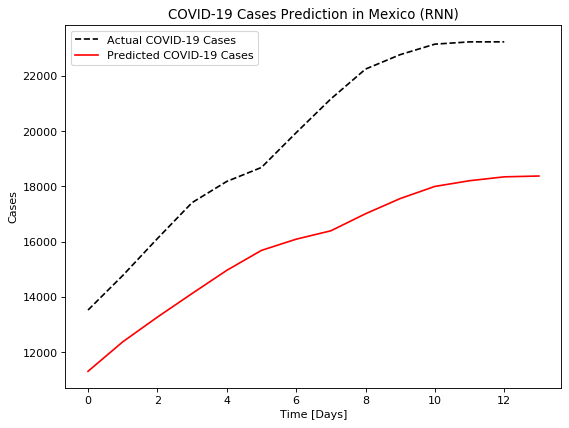

In [268]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(COVID_cases, color = 'black', label = 'Actual COVID-19 Cases', linestyle='dashed')
plt.plot(predicted_cases_RNN, color = 'red', label = 'Predicted COVID-19 Cases')
plt.title('COVID-19 Cases Prediction in Mexico (RNN)')
plt.xlabel('Time [Days]')
plt.ylabel('Cases')
plt.legend()
plt.show()

#### LSTM Prediction

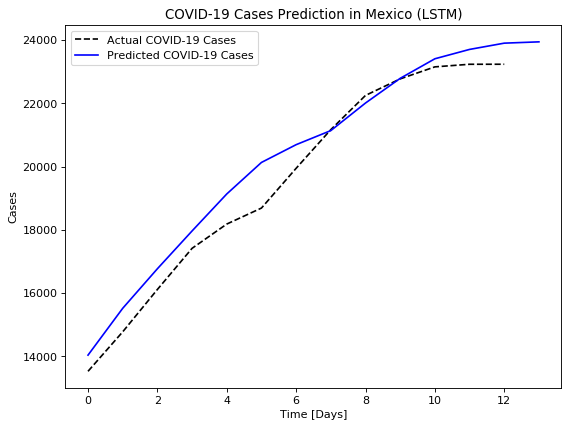

In [269]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(COVID_cases, color = 'black', label = 'Actual COVID-19 Cases', linestyle='dashed')
plt.plot(predicted_cases_LSTM, color = 'blue', label = 'Predicted COVID-19 Cases')
plt.title('COVID-19 Cases Prediction in Mexico (LSTM)')
plt.xlabel('Time [Days]')
plt.ylabel('Cases')
plt.legend()
plt.show()

#### GRU Prediction

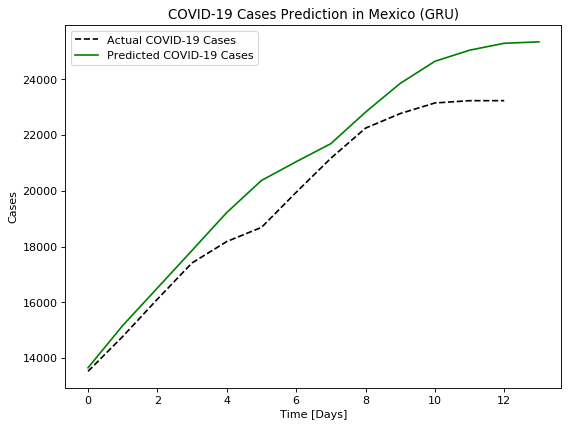

In [270]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(COVID_cases, color = 'black', label = 'Actual COVID-19 Cases', linestyle='dashed')
plt.plot(predicted_cases_GRU, color = 'green', label = 'Predicted COVID-19 Cases')
plt.title('COVID-19 Cases Prediction in Mexico (GRU)')
plt.xlabel('Time [Days]')
plt.ylabel('Cases')
plt.legend()
plt.show()

From the results, we can see that the LSTM and GRU models did far better than the RNN. Furthemore, for only 83 training data samples it is quite impressive that the LSTM and GRU models work so well. The LSTM model, did a bit better overall than the GRU but it uses ~20,000 paramters more than the GRU.

## 3. Mask Detection

This work was taken from company [AIZOOTech](https://github.com/AIZOOTech). Code shown here to show an extra example on how Deep Learning could be used to conbat COVID-19. Please refer to the GitHub repo for instructions on how to run the code.

### Data Set and Model Loading

In [ ]:
dataset_train = pd.read_csv('NSE-TATAGLOBAL.csv')
training_set = dataset_train.iloc[:, 1:2].values
model = load_keras_model('models/face_mask_detection.json', 'models/face_mask_detection.hdf5')

### Anchor Configuration

In [ ]:
feature_map_sizes = [[33, 33], [17, 17], [9, 9], [5, 5], [3, 3]]
anchor_sizes = [[0.04, 0.056], [0.08, 0.11], [0.16, 0.22], [0.32, 0.45], [0.64, 0.72]]
anchor_ratios = [[1, 0.62, 0.42]] * 5
anchors = generate_anchors(feature_map_sizes, anchor_sizes, anchor_ratios)
anchors_exp = np.expand_dims(anchors, axis=0)
id2class = {0: 'Mask', 1: 'NoMask'}

### Run Model

In [ ]:
def inference(image,
              conf_thresh=0.5,
              iou_thresh=0.4,
              target_shape=(160, 160),
              draw_result=True,
              show_result=True
              ):
    '''
    Main function of detection inference
    :param image: 3D numpy array of image
    :param conf_thresh: the min threshold of classification probabity.
    :param iou_thresh: the IOU threshold of NMS
    :param target_shape: the model input size.
    :param draw_result: whether to daw bounding box to the image.
    :param show_result: whether to display the image.
    :return:
    '''
    # image = np.copy(image)
    output_info = []
    height, width, _ = image.shape
    image_resized = cv2.resize(image, target_shape)
    image_np = image_resized / 255.0  # 归一化到0~1
    image_exp = np.expand_dims(image_np, axis=0)

    y_bboxes_output, y_cls_output = keras_inference(model, image_exp)
    # remove the batch dimension, for batch is always 1 for inference.
    y_bboxes = decode_bbox(anchors_exp, y_bboxes_output)[0]
    y_cls = y_cls_output[0]
    # To speed up, do single class NMS, not multiple classes NMS.
    bbox_max_scores = np.max(y_cls, axis=1)
    bbox_max_score_classes = np.argmax(y_cls, axis=1)

    # keep_idx is the alive bounding box after nms.
    keep_idxs = single_class_non_max_suppression(y_bboxes,
                                                 bbox_max_scores,
                                                 conf_thresh=conf_thresh,
                                                 iou_thresh=iou_thresh,
                                                 )

    for idx in keep_idxs:
        conf = float(bbox_max_scores[idx])
        class_id = bbox_max_score_classes[idx]
        bbox = y_bboxes[idx]
        # clip the coordinate, avoid the value exceed the image boundary.
        xmin = max(0, int(bbox[0] * width))
        ymin = max(0, int(bbox[1] * height))
        xmax = min(int(bbox[2] * width), width)
        ymax = min(int(bbox[3] * height), height)

        if draw_result:
            if class_id == 0:
                color = (0, 255, 0)
            else:
                color = (255, 0, 0)
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
            cv2.putText(image, "%s: %.2f" % (id2class[class_id], conf), (xmin + 2, ymin - 2),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, color)
        output_info.append([class_id, conf, xmin, ymin, xmax, ymax])

    if show_result:
        Image.fromarray(image).show()
    return output_info


def run_on_video(video_path, output_video_name, conf_thresh):
    cap = cv2.VideoCapture(video_path)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    # writer = cv2.VideoWriter(output_video_name, fourcc, int(fps), (int(width), int(height)))
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    if not cap.isOpened():
        raise ValueError("Video open failed.")
        return
    status = True
    idx = 0
    while status:
        start_stamp = time.time()
        status, img_raw = cap.read()
        img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
        read_frame_stamp = time.time()
        if (status):
            inference(img_raw,
                      conf_thresh,
                      iou_thresh=0.5,
                      target_shape=(260, 260),
                      draw_result=True,
                      show_result=False)
            cv2.imshow('image', img_raw[:, :, ::-1])
            cv2.waitKey(1)
            inference_stamp = time.time()
            # writer.write(img_raw)
            write_frame_stamp = time.time()
            idx += 1
            print("%d of %d" % (idx, total_frames))
            print("read_frame:%f, infer time:%f, write time:%f" % (read_frame_stamp - start_stamp,
                                                                   inference_stamp - read_frame_stamp,
                                                                   write_frame_stamp - inference_stamp))
    # writer.release()

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Face Mask Detection")
    parser.add_argument('--img-mode', type=int, default=1, help='set 1 to run on image, 0 to run on video.')
    parser.add_argument('--img-path', type=str, help='path to your image.')
    parser.add_argument('--video-path', type=str, default='0', help='path to your video, `0` means to use camera.')
    # parser.add_argument('--hdf5', type=str, help='keras hdf5 file')
    args = parser.parse_args()
    if args.img_mode:
        imgPath = args.img_path
        img = cv2.imread(imgPath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        inference(img, show_result=True, target_shape=(260, 260))
    else:
        video_path = args.video_path
        if args.video_path == '0':
            video_path = 0
        run_on_video(video_path, '', conf_thresh=0.5)

### Result

<center><img src='MaskOn.JPG'></center>

<center><img src='NoMask.JPG'></center>

We can see that the models (based on CNNs) clearly identify face mask on / face mask off.